# Загрузка данных

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime as dt

In [232]:
# Загрузка данных
df = pd.read_csv('to-modal.csv', parse_dates=['dt'], index_col='dt')


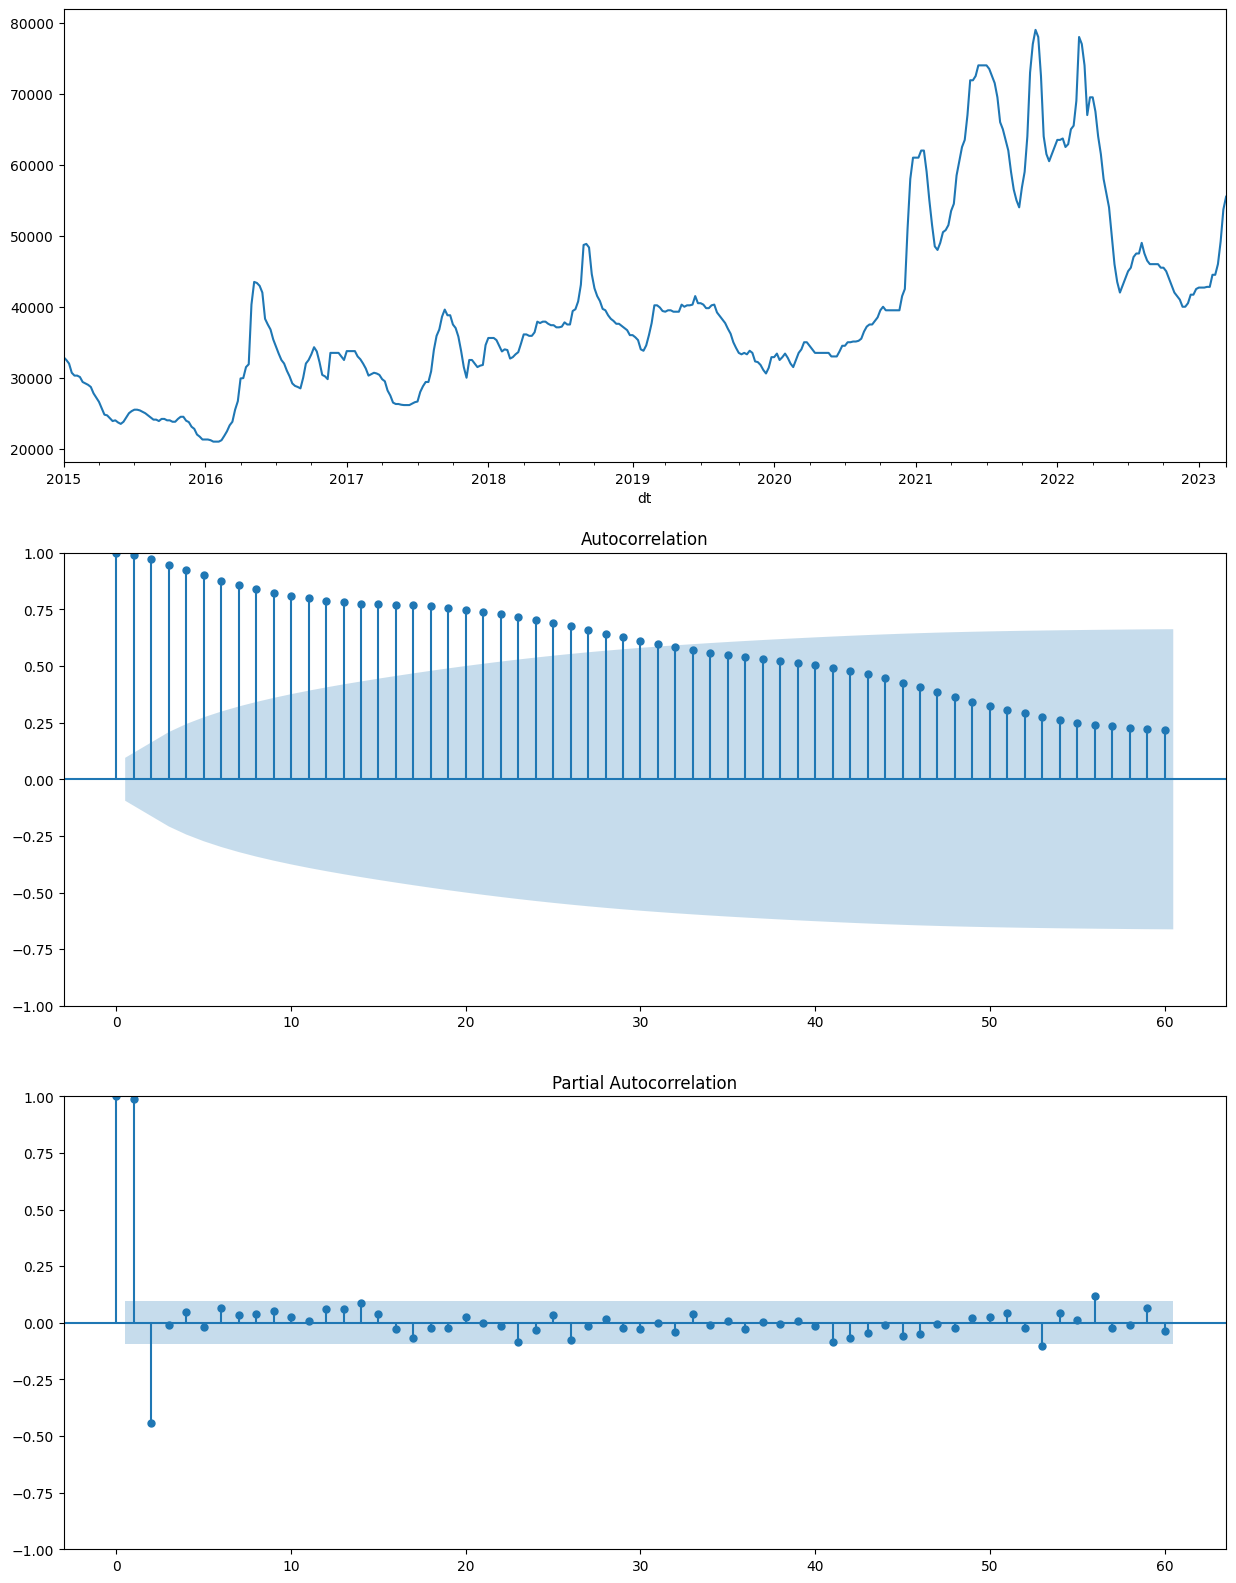

In [233]:
# вывод кореллограмм и ? (аргументировать зачем)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
df['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df['Цена на арматуру'], lags=60, ax=ax[1])
plot_pacf(df['Цена на арматуру'], lags=60, ax=ax[2]);

In [234]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = df.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

# Модели

## catboost

In [235]:
from catboost import CatBoostRegressor

In [236]:
for lag in [1, 2, 3, 6, 12]:
    df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    
df = df.dropna()

In [237]:
# Разделение на обучающую и тестовую выборки
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train.drop(columns=['Цена на арматуру']), train['Цена на арматуру']
X_test, y_test = test.drop(columns=['Цена на арматуру']), test['Цена на арматуру']

In [238]:
# Создание и обучение модели
model = CatBoostRegressor(iterations=5000, 
                          learning_rate=0.01, 
                          depth=1, 
                          loss_function='MAE',
                          has_time=True,
                          early_stopping_rounds=100)

model.fit(X_train, y_train)

# Прогнозирование
predictions = model.predict(X_test)

0:	learn: 6966.0707830	total: 1.23ms	remaining: 6.17s
1:	learn: 6926.9079525	total: 2.16ms	remaining: 5.4s
2:	learn: 6887.3113543	total: 2.87ms	remaining: 4.78s
3:	learn: 6849.1197720	total: 3.47ms	remaining: 4.33s
4:	learn: 6810.1271839	total: 4.82ms	remaining: 4.82s
5:	learn: 6772.7242638	total: 5.84ms	remaining: 4.86s
6:	learn: 6735.0043313	total: 6.7ms	remaining: 4.78s
7:	learn: 6704.8361749	total: 7.7ms	remaining: 4.8s
8:	learn: 6668.1540574	total: 8.67ms	remaining: 4.81s
9:	learn: 6639.8095637	total: 9.61ms	remaining: 4.79s
10:	learn: 6609.7543076	total: 10.5ms	remaining: 4.75s
11:	learn: 6575.2030293	total: 11.2ms	remaining: 4.66s
12:	learn: 6542.0951291	total: 12.4ms	remaining: 4.74s
13:	learn: 6509.0744214	total: 13.4ms	remaining: 4.76s
14:	learn: 6477.5306546	total: 14.6ms	remaining: 4.87s
15:	learn: 6453.4542753	total: 15.6ms	remaining: 4.87s
16:	learn: 6430.1347245	total: 17.1ms	remaining: 5.02s
17:	learn: 6398.2760732	total: 18ms	remaining: 4.99s
18:	learn: 6368.4998819	to

In [239]:
# Оценка модели
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 3721.26
MSE: 26906078.43
RMSE: 5187.11
R²: 0.7903


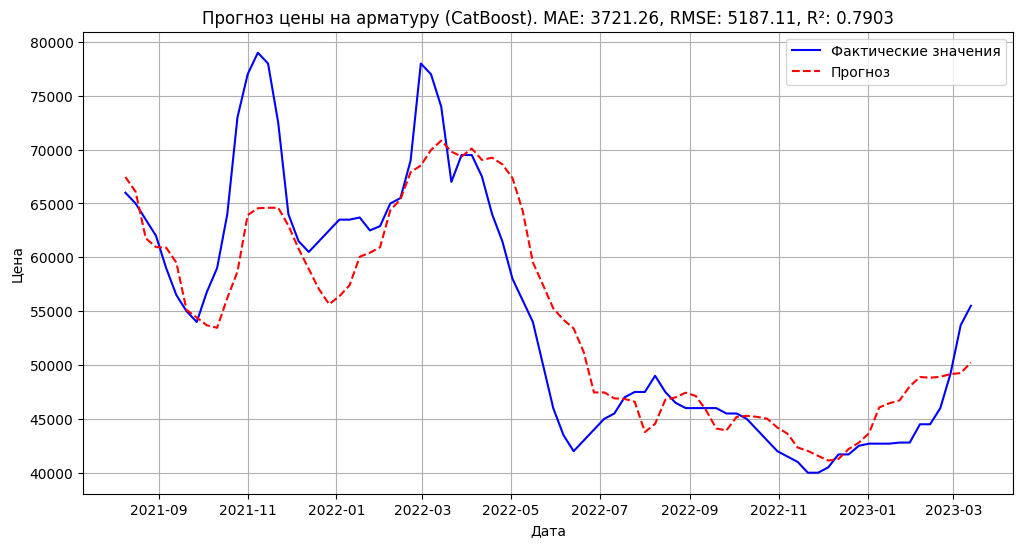

In [240]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Фактические значения', color='blue')
plt.plot(test.index, predictions, label='Прогноз', color='red', linestyle='--')
plt.title(f'Прогноз цены на арматуру (CatBoost). MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

In [241]:
# Получаем важность признаков из модели
feature_importance = model.feature_importances_

# Сортируем индексы по убыванию важности
sorted_idx = np.argsort(feature_importance)[::-1]

# Выбираем топ-15 индексов
top_n = 15
top_feature_indices = sorted_idx[:top_n]

# Если исходный датасет — pandas.DataFrame
if isinstance(X_train, pd.DataFrame):
    # Получаем имена топ-признаков
    top_features = X_train.columns[top_feature_indices].tolist()
    # Создаем новый датасет с отобранными признаками
    X_selected = X_train[top_features]

# Если исходный датасет — numpy.ndarray
else:
    # Создаем новый датасет, выбирая столбцы по индексам
    X_selected = X_train[:, top_feature_indices]

print("Топ-15 признаков:", top_feature_indices)
X_selected

Топ-15 признаков: [47 48 12 11  5 24 27 13 28  4 49 30 41 33  2]


,lag_1,lag_2,"Чугун_FOB Бразилия Север, $/т","Лом_3А, FOB РФ Черное море, $/т","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","Чугун_Россия, FCA руб./т, без НДС","ГБЖ_CFR Италия, $/т","Лом_HMS 1/2 80:20, CFR ЮВА, $/т","Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС",lag_3,"Лом_HMS 1/2 80:20, CFR Турция, $/т","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","Чугун_CFR NOLA США, $/т","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т"
dt,,,,,,,,,,,,,,,
2015-03-30,27800.0,28700.0,269.0,221.0,12569.0,15250.0,249.5,254.0,12113.0,11853.0,29000.0,256.0,77.0,312.0,231.0
2015-04-06,27200.0,27800.0,265.0,229.0,12421.0,13250.0,249.5,258.0,12369.0,11785.0,28700.0,262.0,77.0,312.0,235.0
2015-04-13,26600.0,27200.0,265.0,229.0,12146.0,13250.0,249.5,258.0,12324.0,11327.0,27800.0,263.0,77.0,312.0,238.0
2015-04-20,25700.0,26600.0,265.0,238.0,11716.0,13250.0,249.5,258.0,12109.0,11050.0,27200.0,267.0,77.0,312.0,245.0
2015-04-27,24800.0,25700.0,270.0,243.0,11035.0,13250.0,249.5,258.0,11705.0,11091.0,26600.0,274.0,77.0,312.0,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-05,74000.0,74000.0,615.0,460.0,27889.0,42500.0,517.5,518.0,29662.0,25813.0,74000.0,498.0,218.0,641.5,456.0
2021-07-12,74000.0,74000.0,615.0,458.0,27063.0,42500.0,512.5,518.0,28463.0,25816.0,74000.0,496.0,218.0,625.0,453.0
2021-07-19,73500.0,74000.0,615.0,448.0,25804.0,42500.0,495.0,508.0,27589.0,25855.0,74000.0,486.0,218.0,632.5,441.0


In [242]:
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          early_stopping_rounds=100)

0:	learn: 6966.0707830	test: 20605.5714286	best: 20605.5714286 (0)	total: 1.15ms	remaining: 5.74s
1:	learn: 6926.9079525	test: 20551.0514299	best: 20551.0514299 (1)	total: 2.17ms	remaining: 5.43s
2:	learn: 6887.3113543	test: 20497.0766313	best: 20497.0766313 (2)	total: 3.09ms	remaining: 5.15s
3:	learn: 6849.1197720	test: 20443.6415787	best: 20443.6415787 (3)	total: 4.17ms	remaining: 5.2s
4:	learn: 6810.1271839	test: 20391.7408768	best: 20391.7408768 (4)	total: 5.05ms	remaining: 5.04s
5:	learn: 6772.7242638	test: 20342.3591836	best: 20342.3591836 (5)	total: 5.96ms	remaining: 4.96s
6:	learn: 6735.0043313	test: 20291.4713087	best: 20291.4713087 (6)	total: 7.12ms	remaining: 5.08s
7:	learn: 6704.8361749	test: 20240.0923108	best: 20240.0923108 (7)	total: 7.93ms	remaining: 4.95s
8:	learn: 6668.1540574	test: 20190.2271020	best: 20190.2271020 (8)	total: 8.72ms	remaining: 4.83s
9:	learn: 6639.8095637	test: 20139.8605455	best: 20139.8605455 (9)	total: 9.41ms	remaining: 4.7s
10:	learn: 6609.754307

In [243]:
predictions = model.predict(X_test)

In [244]:
# Оценка модели
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 3777.26
MSE: 27725160.05
RMSE: 5265.47
R²: 0.7839


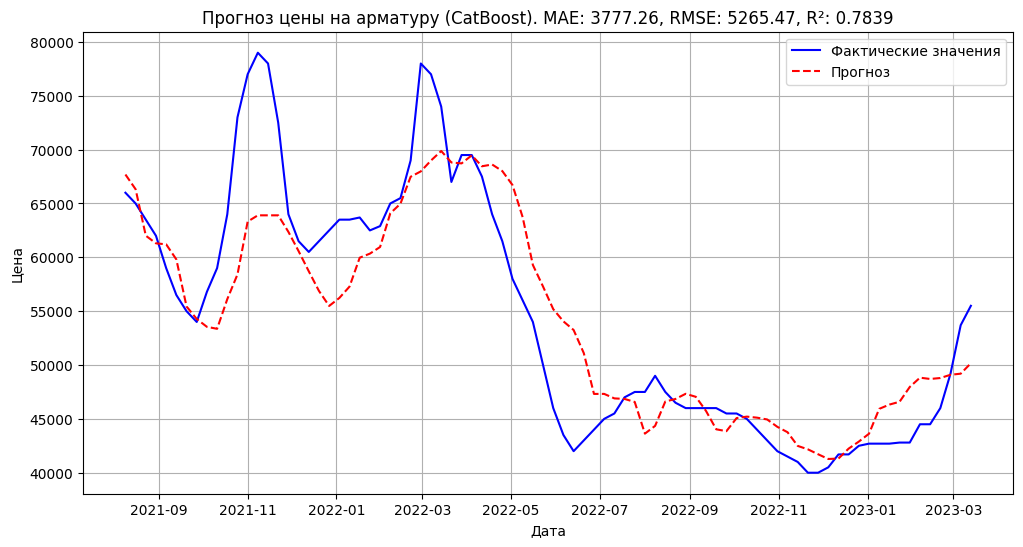

In [245]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Фактические значения', color='blue')
plt.plot(test.index, predictions, label='Прогноз', color='red', linestyle='--')
plt.title(f'Прогноз цены на арматуру (CatBoost). MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

In [246]:
import pickle
with open('catboost_model.pkl', 'wb') as f: pickle.dump(model, f)